# Library Load

In [ ]:
! pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 44.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import recall_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix,csr_matrix
from konlpy.tag import Kkma
import re

import tensorflow as tf
import keras.backend as K
import keras
from keras import regularizers,optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization,Reshape, Input, LSTM, GRU,Multiply,Add,Concatenate,Layer,Attention,Embedding,Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving apply_train.csv to apply_train.csv
Saving company.csv to company.csv
Saving recruitment.csv to recruitment.csv
Saving recruitment_embedding.pickle to recruitment_embedding.pickle
Saving resume.csv to resume.csv
Saving resume_certificate.csv to resume_certificate.csv
Saving resume_education.csv to resume_education.csv
Saving resume_embedding.pickle to resume_embedding.pickle
Saving resume_language.csv to resume_language.csv
Saving sample_submission.csv to sample_submission.csv


In [ ]:
import pickle
with open('resume_embedding.pickle','rb') as f:
    resume_graph_emb= pickle.load(f)

In [ ]:
import pickle
with open('recruitment_embedding.pickle','rb') as f:
    item_graph_emb= pickle.load(f)

In [ ]:
apply_train  = pd.read_csv('apply_train.csv')
resume_certi  = pd.read_csv('resume_certificate.csv')
resume_edu  = pd.read_csv('resume_education.csv')
resume_lang  = pd.read_csv('resume_language.csv')
resume  = pd.read_csv('/content/resume.csv')
sample_submission  = pd.read_csv('sample_submission.csv')
recruit  = pd.read_csv('recruitment.csv')
company  = pd.read_csv('company.csv')

# Functions

In [ ]:
def transfrom_comma(df,column):
    new_comma=[]
    for idx,h in enumerate(df[column]):
        try:
            new = h.replace(';',',')
            new_comma.append(new)
        except AttributeError:
            new_comma.append('0')
    df.drop(column,axis=1,inplace=True)
    return new_comma

def doc2vec(df,column,num_vec):
    tagged_corpus_list_tr = []
    # 각 문장마다 Tag달아주기
    for index, row in tqdm(df.iterrows(), total=len(df)):
        text = row[column]
        tagged_corpus_list_tr.append(TaggedDocument(tags=['id'+str(index)], words=text))

    print('문서의 수 :', len(tagged_corpus_list_tr))
    # 휴리스틱하게 정한 파라미터
    model_d2v = Doc2Vec(dm=0, # dm = 1 for ‘distributed memory’ model
                                      dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                      vector_size=num_vec, # no. of desired features
                                      window=2, # width of the context window
                                      negative=1, # if > 0 then negative sampling will be used
                                      min_count=1, # Ignores all words with total frequency lower than 3.
                                      workers=32, # no. of cores
                                      alpha=0.1, # learning rate
                                      seed = 1992, # for reproducibility
                                     )
        # 사전구축 및 모델 학습
    model_d2v.build_vocab([i for i in tqdm(tagged_corpus_list_tr)])

    model_d2v.train(tagged_corpus_list_tr, total_examples= len(df), epochs=70)
    # Vector뽑아서 DataFrame형태로 만들기
    docvec_arrays = np.zeros((len(df), num_vec))
    for i in range(0,len(df)):
        docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,num_vec))
    doc_vectors = pd.DataFrame(docvec_arrays)
    doc_vectors.columns = [f'{column}'+str(i) for i in range(1,num_vec+1)]
    return doc_vectors

def fillna(df):
    df.fillna('0',inplace=True)
    return df
def fillna2(df):
    df.fillna(0,inplace=True)
    return df

def furier_transform(df,column):
    df['year']= pd.to_datetime(df[column]).dt.year
    df['month']=pd.to_datetime(df[column]).dt.month
    df['day']=pd.to_datetime(df[column]).dt.day
    month_in_year = 12
    df[f'{column}_month_sin'] = np.sin(2*np.pi*df.month/month_in_year)
    df[f'{column}_month_cos'] = np.cos(2*np.pi*df.month/month_in_year)
    days_in_month = 30
    df[f'{column}_day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
    df[f'{column}_day_cos'] = np.cos(2*np.pi*df.day/days_in_month)
    df.drop([column,'month','day'],axis=1,inplace=True)
    return df

def text_preprocessor(s):
    import re

    ## (1) [], (), {}, <> 괄호와 괄호 안 문자 제거하기
    pattern = r'\([^)]*\)'  # ()
    s = re.sub(pattern=pattern, repl='', string=str(s))


    ## (3) 특수문자 제거
    pattern = r'[^a-zA-Z가-힣]'
    s = re.sub(pattern=pattern, repl=' ', string=str(s))

    # (5) 공백 기준으로 분할하기
    s_split = s.split()

    return s_split

def words_tokonizer(text):
    from konlpy.tag import Kkma # NLP of the Korean language
    kkma = Kkma()

    words = []

    # Text preprocessing using the UDF above
    s_list = text_preprocessor(text)

    # POS tagging
    for s in s_list:
        words_ = kkma.pos(s)

        # NNG indexing
        for word in words_:
            if word[1] == 'NNG':
                words.append(word[0])

    return words
def join(x):
    r = "".join(x)
    return r
def recall5(answer_df, submission_df):
    """
    Calculate recall@5 for given dataframes.

    Parameters:
    - answer_df: DataFrame containing the ground truth
    - submission_df: DataFrame containing the predictions

    Returns:
    - recall: Recall@5 value
    """

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # Check if each primary_col entry has exactly 5 secondary_col predictions
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # Check for NULL values in the predicted secondary_col
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # Check for duplicates in the predicted secondary_col for each primary_col
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    recall = np.mean(individual_recalls)
    return recall

# Item Embedding

In [ ]:
recruit = recruit.sort_values('recruitment_seq').reset_index(drop=True)
recruit.drop(['career_end','career_start'],axis=1,inplace=True) #0인 열은 삭제
recruit['address_seq1'].fillna(3,inplace=True)
recruit.drop(['address_seq2','address_seq3'],axis=1,inplace=True) #NaN많은 열은 삭제
recruit['check_box_keyword'] = transfrom_comma(recruit,'check_box_keyword')
recruit['text_keyword'] = transfrom_comma(recruit,'text_keyword')
recruit['obj_col'] = recruit['check_box_keyword']+','+recruit['text_keyword']
recruit.drop(['check_box_keyword','text_keyword'],axis=1,inplace=True)
tk = doc2vec(recruit,'obj_col',10)
recruit_2 = pd.concat([recruit,tk],axis=1)
recruit_2.drop('obj_col',axis=1,inplace=True)
company = company.sort_values('recruitment_seq').reset_index(drop=True)
company
item_df = pd.merge(recruit_2,company,how='left',on='recruitment_seq')
item_df = fillna2(item_df)
obj_col = item_df.iloc[:,5:15].columns
scaling_df = item_df.drop(obj_col,axis=1).iloc[:,1:]
#scaler_ = MinMaxScaler()
#scaled_col = scaler_.fit_transform(scaling_df)
item_scaled_df = pd.concat([scaling_df,item_df[obj_col]],axis=1)

100%|██████████| 6695/6695 [00:00<00:00, 22924.62it/s]


문서의 수 : 6695


100%|██████████| 6695/6695 [00:00<00:00, 2603454.97it/s]
<ipython-input-9-522c810cfd40>:38: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,num_vec))


# Resume Embedding

In [ ]:
resume= resume.sort_values('resume_seq').reset_index(drop=True)
resume_1 = furier_transform(resume,'reg_date')
resume_2 = furier_transform(resume_1,'updated_date')
resume_2['new_text_keyword'] = transfrom_comma(resume_2,'text_keyword')
vec_text_keyword = doc2vec(resume_2,'new_text_keyword',10)
resume_3 = pd.concat([resume_2,vec_text_keyword],axis=1)
resume_3.drop('new_text_keyword',axis=1,inplace=True)
resume_3['job_code_seq2'].fillna('0',inplace=True)
resume_3['job_code_seq3'].fillna('0',inplace=True)
resume_3[['career_job_code']].fillna('0',inplace=True)
categorical_col = ['job_code_seq1','career_job_code','degree','graduate_date','year']
for c in categorical_col:
    le = LabelEncoder()
    resume_3[c] = le.fit_transform(resume_3[c])
resume_3.drop(['job_code_seq2','job_code_seq3'],axis=1,inplace=True)
resume_3['hope_salary'] = resume_3['hope_salary'].astype(dtype='float32')
resume_3['last_salary'] = resume_3['last_salary'].astype(dtype='float32')
resume_certi = fillna(resume_certi)
resume_certi['items_list'] = resume_certi['certificate_contents'].apply(lambda s: text_preprocessor(s))
resume_certi['items_list_joined'] = resume_certi['items_list'].apply(lambda x: join(x))
for idx in range(len(resume_certi)):
    if '운전' in resume_certi['items_list_joined'][idx]:
        resume_certi['items_list_joined'][idx] = '운전'
documents = resume_certi['items_list_joined']

# TF-IDF 변환기 생성
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF 행렬 계산
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

# TF-IDF 행렬을 밀집 배열로 변환
tfidf_array = tfidf_matrix.toarray()
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(tfidf_array)
resume_certi['clusterd'] = kmeans.predict(tfidf_array)
resume_certi = resume_certi.sort_values('resume_seq').reset_index(drop=True)
resume_certi = resume_certi.sort_values('resume_seq').reset_index(drop=True)
resume_certi_new = resume_certi[['resume_seq','clusterd']]
resume_certi_new = resume_certi_new.groupby('resume_seq').agg(list)
resume_certi_new['lenth_certi']=[len(x) for x in resume_certi_new['clusterd']]
resume_certi_new['clusterd'] = [list(set(x)) for x in resume_certi_new['clusterd']]
padded_certi = pad_sequences(resume_certi_new['clusterd'].values,padding='post',value=-999)
padded_certi_df = pd.DataFrame(padded_certi,index=resume_certi_new.index)
resume_certi_new2 = pd.concat([padded_certi_df,resume_certi_new['lenth_certi']],axis=1)
resume_edu = fillna(resume_edu)
obj_columns = resume_edu.columns[resume_edu.dtypes=='object']
le = LabelEncoder()
for col in obj_columns[1:]:
    resume_edu[col] =le.fit_transform(resume_edu[col])
resume_edu = resume_edu.sort_values('resume_seq').reset_index(drop=True)
resume_lang = resume_lang.sort_values('resume_seq').reset_index(drop=True)
resume_score = resume_lang[['resume_seq','score']].groupby('resume_seq').sum()
merge_certi = pd.merge(resume_3,resume_certi_new,on='resume_seq',how='left')
merge_edu = pd.merge(merge_certi,resume_edu,on='resume_seq',how='left')
merge_resume_all = pd.merge(merge_edu,resume_score,on='resume_seq',how='left')
merge_resume_all.fillna(0,inplace=True)
merge_resume_all.drop('clusterd',axis=1,inplace=True)
resume_all = merge_resume_all.drop('resume_seq',axis=1)

100%|██████████| 8482/8482 [00:00<00:00, 22416.67it/s]


문서의 수 : 8482


100%|██████████| 8482/8482 [00:00<00:00, 2824171.35it/s]
<ipython-input-9-522c810cfd40>:38: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,num_vec))
<ipython-input-11-361c93764579>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resume_3[['career_job_code']].fillna('0',inplace=True)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Make X,y

In [ ]:
apply_train = apply_train.sort_values('resume_seq').reset_index(drop=True)
apply_train['resume_seq_drop']= [int(x[2:])for x in apply_train['resume_seq']]
apply_train['item_seq_drop']= [int(x[2:])for x in apply_train['recruitment_seq']]
apply_train['rating'] = 1
drop_df = apply_train.drop(['resume_seq','recruitment_seq'],axis=1)

In [ ]:
apply_train

,resume_seq,recruitment_seq,resume_seq_drop,item_seq_drop,rating
0,U00001,R05210,1,5210,1
1,U00001,R05288,1,5288,1
2,U00001,R04536,1,4536,1
3,U00001,R06065,1,6065,1
4,U00002,R01103,2,1103,1
...,...,...,...,...,...
57941,U08481,R00225,8481,225,1
57942,U08481,R05500,8481,5500,1
57943,U08482,R03633,8482,3633,1
57944,U08482,R03743,8482,3743,1


In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT:
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items

        OUTPUT:
            matrix: 2D numpy array.
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])

    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
num_users = drop_df['resume_seq_drop'].unique().max()+1
num_items = drop_df['item_seq_drop'].unique().max()+1
users_items_matrix_train_zero = dataPreprocessor(drop_df, num_users, num_items, 0)
users_items_matrix_train_zero = users_items_matrix_train_zero[1:,1:]

In [ ]:
def masked_mse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
scaler_ = StandardScaler()
scaled_col = scaler_.fit_transform(item_scaled_df.iloc[:,:7].values)
scaled_item = np.hstack((scaled_col,item_scaled_df.iloc[:,7:].values))

In [ ]:
resume_all.drop('year',axis=1,inplace=True)
catecol = resume_all.columns[resume_all.dtypes!='float64']
floatcol = resume_all.columns[resume_all.dtypes=='float64']
scaled = resume_all[catecol].values
no_scaled = resume_all[floatcol].values
scaled_col2 = scaler_.fit_transform(scaled)
scaled_resume = np.hstack((scaled_col2,no_scaled))
resume_dfed = pd.DataFrame(scaled_resume)
#resume_dfed.drop(37,axis=1,inplace=True)
resume_dfed[37] = scaler_.fit_transform(resume_dfed[37].values.reshape(-1,1))
resume_dfed[38] = scaler_.fit_transform(resume_dfed[38].values.reshape(-1,1))
resume_dfed[39] = scaler_.fit_transform(resume_dfed[39].values.reshape(-1,1))
scaled_resume2 = resume_dfed.values

In [ ]:
# 사용자 간의 유사성 계산
resume_similarity = cosine_similarity(scaled_resume2)
# 아이템 간의 유사성 계산
item_similarity = cosine_similarity(scaled_item)

In [ ]:
pd.DataFrame(users_items_matrix_train_zero)

,0,1,2,3,4,5,6,7,8,9,...,6685,6686,6687,6688,6689,6690,6691,6692,6693,6694
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.DataFrame(scaled_item)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.985038,-1.436490,-0.223415,-0.664275,2.261049,0.432504,2.481967,0.080517,-0.309212,-0.101485,-0.428031,-0.200508,-0.126936,-0.863856,0.150447,-0.335852,0.293758
1,-0.108508,-0.108500,-0.223415,-0.664275,0.545791,0.432504,0.370737,0.249048,-0.548084,-0.826752,0.201908,-0.173085,-0.482573,0.177649,0.269697,-0.071290,-0.164621
2,-0.108508,-0.108500,-0.223415,1.428581,-0.597714,-0.670237,-0.346453,-0.130870,-0.718334,-0.309942,-0.355473,-0.167415,0.026134,-0.550720,0.071213,-0.149872,0.088370
3,-0.108508,-0.108500,-0.223415,-0.664275,0.545791,1.535245,1.894767,-0.361822,-0.023990,-0.155571,0.155156,-0.251130,-0.751176,-0.079309,0.205581,0.097807,-0.329180
4,-0.108508,-0.108500,-0.223415,-0.664275,-0.597714,-0.670237,-0.346453,-0.126648,-0.125724,-0.571816,0.078672,-0.055979,-0.753216,0.003787,0.358401,0.029642,-0.154711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,-0.108508,-0.108500,-0.223415,-0.664275,-0.597714,-0.670237,-0.346453,-0.332807,-0.131621,-0.082466,-0.086121,-0.347263,-0.569507,-0.376909,0.231157,0.060513,-0.174116
6691,-0.108508,-0.108500,-0.223415,1.428581,1.689297,1.535245,0.325913,-0.011487,-0.146097,-0.273926,-0.248354,-0.058657,-0.271330,-0.078171,0.119812,-0.377710,0.111918
6692,1.985038,1.219489,-0.223415,-0.664275,-0.597714,-0.670237,-0.346453,-0.021100,-0.232427,-0.104076,0.129394,-0.246534,-0.416182,-0.118841,0.120488,-0.222368,0.124448
6693,-0.108508,1.219489,-0.223415,-0.664275,-0.597714,-0.670237,-0.346453,0.361275,-0.758747,-0.618066,-0.179026,-0.314987,0.327581,-0.181790,-0.133232,-0.331623,-0.102785


In [ ]:
item_graph_df = pd.DataFrame(item_graph_emb).T
item_graph_df.index = [int(x[2:]) for x in item_graph_df.index]
item_graph_df.sort_index(ascending=True,inplace=True)
item_graph_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,-0.204475,-0.067684,-0.088881,0.186485,0.072812,0.298775,-0.020649,-0.321115,0.121092,-0.192950,...,0.368540,-0.077569,-0.022366,0.217256,-0.053161,0.122050,-0.023775,0.451745,-0.028377,0.020314
2,0.283361,0.122172,0.109598,0.706760,0.173943,0.077878,-0.011395,-0.445283,0.023632,-0.368605,...,-0.246161,0.505142,0.081812,0.077528,0.219359,0.171614,-0.157852,-0.043347,-0.167919,0.033651
3,-0.093583,0.087343,0.000333,0.119392,0.195137,-0.562805,-0.206737,0.229214,0.236773,-0.081933,...,0.019452,0.155063,0.596319,-0.054645,-0.076242,-0.105423,-0.257561,0.079393,-0.273726,0.138518
4,0.154996,0.174909,-0.237541,-0.025443,0.049607,0.056206,-0.332326,-0.094420,-0.075585,0.304678,...,0.258952,-0.010874,0.135330,-0.034969,0.710642,-0.172938,-0.073454,0.049247,0.328055,-0.045707
5,-0.035455,-0.298992,-0.213716,0.132706,-0.191441,-0.068649,0.293093,-0.187920,-0.282236,0.080310,...,0.166685,-0.115453,0.340010,-0.103245,-0.140578,-0.108087,0.109915,0.024762,0.073807,0.260711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,-0.387609,-0.389846,0.269189,0.288839,0.153905,0.396945,-0.646924,-0.066286,-0.020268,0.079168,...,-0.286443,-0.188661,0.101901,-0.030174,-0.104021,-0.185926,-0.063074,-0.254913,0.040736,-0.146016
6692,0.162923,0.197810,-0.360163,0.458436,0.125254,0.244269,-0.246149,-0.228896,-0.200346,-0.064963,...,0.525445,0.205142,-0.131380,0.219476,0.211719,-0.162748,0.116572,0.091636,0.047390,0.038130
6693,-0.273186,0.024333,0.255244,-0.009982,-0.155851,-0.328555,0.207221,-0.166752,-0.043617,-0.097862,...,0.236145,0.077347,-0.012752,0.180866,0.324460,0.143968,0.111173,0.137136,0.386007,-0.241224
6694,-0.129525,-0.003490,0.149129,0.087480,-0.086199,-0.191038,0.416431,0.114362,0.190760,-0.219150,...,-0.258497,-0.149910,0.258777,0.041698,-0.213402,0.058698,-0.341351,-0.182611,0.099729,0.135554


In [ ]:
resume_graph_df = pd.DataFrame(resume_graph_emb).T
resume_graph_df.index = [int(x[2:]) for x in resume_graph_df.index]
resume_graph_df.sort_index(ascending=True,inplace=True)
resume_graph_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,-0.023198,0.081996,0.191962,-0.156288,-0.070828,-0.188254,-0.071565,0.205530,-0.030294,0.251102,...,-0.032503,-0.198348,0.044004,0.105660,0.320761,0.235790,-0.287073,-0.126114,-0.025141,-0.156119
2,-0.249720,-0.272900,0.081555,0.066741,0.100452,0.050374,0.482573,0.075065,-0.340622,-0.028622,...,-0.659763,0.283036,-0.234974,-0.065569,-0.524676,-0.177365,0.540508,-0.354748,-0.363626,0.138586
3,-0.018211,-0.010575,-0.224856,-0.213493,-0.409658,0.181837,0.029346,-0.323223,-0.227919,-0.099216,...,0.287777,-0.080628,0.161572,0.205948,-0.106525,-0.010701,0.172343,-0.210028,-0.325641,0.120033
4,-0.100003,0.374996,-0.513101,-0.270434,0.285893,-0.011303,-0.517596,-0.180226,-0.145114,0.104897,...,-0.033925,-0.117203,-0.549177,0.097622,0.252122,-0.331207,-0.306970,-0.210773,0.034280,-0.139675
5,-0.082902,-0.388273,-0.039966,0.405246,-0.249024,0.126238,0.221623,0.036421,0.131413,0.013300,...,0.034304,-0.054760,-0.133828,-0.358739,0.009634,-0.224839,0.008090,-0.023274,0.065694,-0.076778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,-0.105224,-0.183443,0.295370,0.124659,-0.067469,-0.135209,0.042391,0.208664,0.009869,0.113639,...,0.287814,0.221756,0.043377,0.260209,-0.062264,-0.009231,0.017487,-0.042027,-0.119415,-0.173984
8479,0.298716,0.276380,0.081002,-0.155894,0.201452,-0.190311,-0.068634,-0.375494,-0.032644,-0.362279,...,0.015093,0.196711,0.025591,0.289143,-0.281700,0.039514,-0.226136,-0.020021,-0.008644,-0.431851
8480,-0.034037,0.077386,0.094575,0.005784,-0.184972,0.032522,0.032896,-0.148125,0.090788,0.149052,...,0.080004,-0.006694,-0.063970,-0.214330,0.175646,0.206451,-0.155769,0.110592,0.096976,-0.064224
8481,-0.075287,-0.432581,-0.171149,-0.049565,-0.019263,0.041537,0.491059,0.062980,-0.264049,-0.204457,...,-0.034007,0.248032,-0.270392,0.064919,0.128634,0.241041,-0.296739,-0.209594,-0.264608,0.124562


# Model Arc

In [ ]:
resume_input = Input(shape=(6695,))
item_input =  Input(shape=(8482,))
item_info = Input(shape=(128,))
resume_info = Input(shape=(128,))
xavier_initializer = tf.keras.initializers.GlorotNormal()
he_initializer = tf.keras.initializers.he_normal()

#resume_autoencoder
#dot_layer_r = tf.tensordot(resume_input,scaled_item.astype('float32'),axes=1)
#concat_layer_r = Concatenate()([resume_input,dot_layer_r])
encoded_r = Dense(700,activation='elu',activity_regularizer=regularizers.l2(0.001))(resume_input)
encoded_r = Dense(300, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(encoded_r)
latent_r = Dense(128, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(encoded_r)
#Add_graph = Add()([latent_r,resume_info])
concat_graph_r = Concatenate()([latent_r,resume_info])
decoded_r = Dense(300, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(concat_graph_r)
decoded_r = Dense(700, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(decoded_r)
drop_r = Dropout(0.3)(decoded_r)
out_r = Dense(6695, activation='relu',activity_regularizer=regularizers.l2(0.0001))(drop_r)

#item_autoencoder
#dot_layer_i = tf.tensordot(item_input,scaled_resume2.astype('float32'),axes=1)
#concat_layer_i = Concatenate()([item_input,dot_layer_i])
encoded_i = Dense(800, activation='elu',activity_regularizer=regularizers.l2(0.001))(item_input)
encoded_i = Dense(500, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(encoded_i)
latent_i = Dense(200, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(encoded_i)
#Add_graph2 = Add()([latent_i,item_info])
concat_graph_i = Concatenate()([latent_i,item_info])
decoded_i = Dense(200, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(concat_graph_i)
decoded_i = Dense(800, activation='elu',activity_regularizer=regularizers.l2(0.001),kernel_initializer=he_initializer)(decoded_i)
drop_i = Dropout(0.45)(decoded_i)
out_i = Dense(8482, activation='relu',activity_regularizer=regularizers.l2(0.0001))(drop_i)

autoencoder_r = Model([resume_input,resume_info], out_r)
autoencoder_i = Model([item_input,item_info], out_i)
# 모델 요약
autoencoder_r.summary()
autoencoder_i.summary()
# 모델 compile
adam = keras.optimizers.Adam(lr=0.001, clipvalue=0.8)
adam2 = keras.optimizers.Adam(lr=0.001, clipvalue=0.8)
autoencoder_r.compile(optimizer=adam, loss=masked_mse)
autoencoder_i.compile(optimizer=adam2, loss=masked_mse)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_75"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_135 (InputLayer)      [(None, 6695)]               0         []                            
                                                                                                  
 dense_507 (Dense)           (None, 700)                  4687200   ['input_135[0][0]']           
                                                                                                  
 dense_508 (Dense)           (None, 300)                  210300    ['dense_507[0][0]']           
                                                                                                  
 dense_509 (Dense)           (None, 128)                  38528     ['dense_508[0][0]']           
                                                                                           

# Train

In [ ]:
#기본 파라미터 세팅
batch_size = 512
epochs = 100
verbose = 1
earlystopping = EarlyStopping(monitor='loss',  # 모니터 기준 설정 (val loss)
                                 patience=15
                                ,verbose=0, restore_best_weights=True) # 15회 Epoch동안 개선되지 않는다면 종료
model_path = f'./latent_cross_autorec'
mc = ModelCheckpoint(filepath=model_path, save_best_only=False, monitor='loss', mode='auto', verbose=0)

Epoch 1/500
17/17 [==============================] - 2s 18ms/step - loss: 0.7090
Epoch 2/500
17/17 [==============================] - 0s 15ms/step - loss: 0.2562
Epoch 3/500
17/17 [==============================] - 0s 15ms/step - loss: 0.1233
Epoch 4/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0876
Epoch 5/500
17/17 [==============================] - 0s 16ms/step - loss: 0.0735
Epoch 6/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0653
Epoch 7/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0596
Epoch 8/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0555
Epoch 9/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0520
Epoch 10/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0490
Epoch 11/500
17/17 [==============================] - 0s 15ms/step - loss: 0.0464
Epoch 12/500
17/17 [==============================] - 0s 14ms/step - loss: 0.0442
Epoch 13/500
17/17 [=====

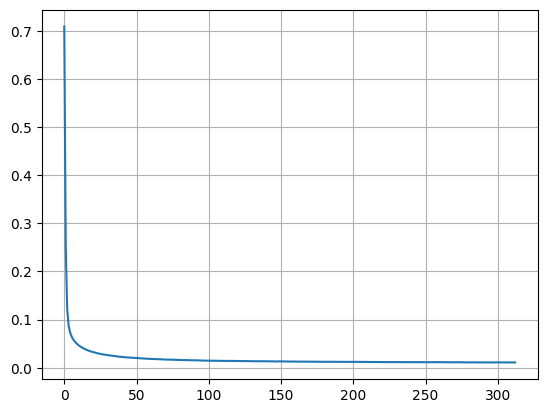

In [ ]:
with tf.device('/device:GPU:0'):
    # 모델 학습
    model_fit = autoencoder_r.fit([users_items_matrix_train_zero.astype(np.float32),resume_graph_df.values],
                     users_items_matrix_train_zero.astype(np.float32),
                    batch_size=512,
                    epochs = 500,
                    callbacks=[ earlystopping],
                    #validation_data=([X_test,X_test_item],y_test),
                    verbose=verbose)

    plt.plot(pd.DataFrame(model_fit.history))
    plt.grid(True)
    plt.show()

In [ ]:
resume_vec = autoencoder_r.predict([users_items_matrix_train_zero.astype(np.float32),resume_graph_df.values])

266/266 [==============================] - 1s 2ms/step


In [ ]:
pd.DataFrame(resume_vec)

,0,1,2,3,4,5,6,7,8,9,...,6685,6686,6687,6688,6689,6690,6691,6692,6693,6694
0,0.0,0.038663,0.000000,0.119142,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.027974,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.170561,0.0,0.0,0.00000,0.0
2,0.0,0.001917,0.000000,0.000000,0.381591,0.016128,0.0,0.000000,0.01815,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
3,0.0,0.000000,0.000000,0.962357,0.000000,0.000000,0.0,0.000000,0.00000,0.075283,...,0.000000,0.0,0.206739,0.0,0.037514,0.000000,0.0,0.0,0.00000,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.013218,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.24192,0.0
8478,0.0,0.392311,0.000000,0.000000,0.000000,0.056634,0.0,0.058849,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
8479,0.0,0.000000,0.058891,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.129884,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.0
8480,0.0,0.000000,0.000000,0.029739,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.004628,0.0,0.0,0.00000,0.0


In [ ]:
np.argsort(resume_vec[0])[::-1][:10]+1

array([4536, 6065, 5210, 5288, 1528, 3021, 3777, 2064, 3811,  165])

Epoch 1/500
14/14 [==============================] - 3s 25ms/step - loss: 0.7511
Epoch 2/500
14/14 [==============================] - 0s 19ms/step - loss: 0.3201
Epoch 3/500
14/14 [==============================] - 0s 18ms/step - loss: 0.1692
Epoch 4/500
14/14 [==============================] - 0s 18ms/step - loss: 0.1156
Epoch 5/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0932
Epoch 6/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0816
Epoch 7/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0742
Epoch 8/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0688
Epoch 9/500
14/14 [==============================] - 0s 18ms/step - loss: 0.0648
Epoch 10/500
14/14 [==============================] - 0s 20ms/step - loss: 0.0615
Epoch 11/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0590
Epoch 12/500
14/14 [==============================] - 0s 19ms/step - loss: 0.0563
Epoch 13/500
14/14 [=====

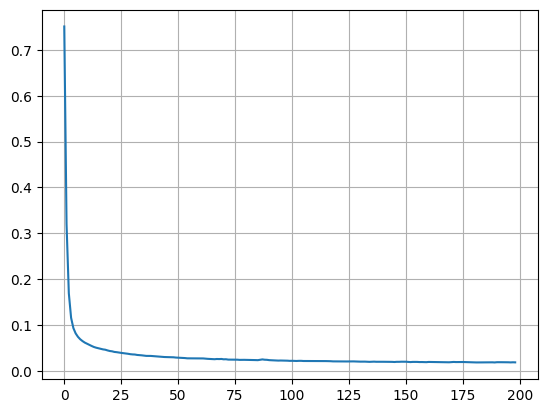

In [ ]:
with tf.device('/device:GPU:0'):
    # 모델 학습
    model_fit = autoencoder_i.fit([users_items_matrix_train_zero.T.astype(np.float32),item_graph_df.values],
                     users_items_matrix_train_zero.T.astype(np.float32),
                    batch_size=512,
                    epochs = 500,
                    callbacks=[ earlystopping],
                    #validation_data=([X_test,X_test_item],y_test),
                    verbose=verbose)

    plt.plot(pd.DataFrame(model_fit.history))
    plt.grid(True)
    plt.show()

# Inference

In [ ]:
#resume_vec = autoencoder_r.predict(users_items_matrix_train_zero.astype(np.float32))
item_vec = autoencoder_i.predict([users_items_matrix_train_zero.T.astype(np.float32),item_graph_df.values])

210/210 [==============================] - 1s 2ms/step


In [ ]:
resume_df = pd.DataFrame(resume_vec)
item_df = pd.DataFrame(item_vec.T)

In [ ]:
resume_weight = resume_vec / (resume_vec + item_vec.T)
item_weight = item_vec.T / (resume_vec + item_vec.T)

<ipython-input-260-02b2847967d8>:1: RuntimeWarning: invalid value encountered in divide
  resume_weight = resume_vec / (resume_vec + item_vec.T)
<ipython-input-260-02b2847967d8>:2: RuntimeWarning: invalid value encountered in divide
  item_weight = item_vec.T / (resume_vec + item_vec.T)


In [ ]:
weighted_vec = (resume_vec*resume_weight)+(item_vec.T*item_weight)

In [ ]:
ews_vec = (resume_vec+item_vec.T) /2

In [ ]:
np.argsort(weighted_vec[0])[::-1][:10]+1

array([6695, 2398, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383])

In [ ]:
np.argsort(ews_vec[0])[::-1][:10]+1

array([5288, 6065, 4536, 5210, 1528, 3021, 3777, 3811,  165, 2064])

# Filtering

In [ ]:
def post_processing(array):
    candidates=[]
    for idx in range(0,8482):
        candidates.append(np.argsort(array[idx])[::-1][:83]+1)
    already_apply = apply_train.groupby('resume_seq').agg(list)['item_seq_drop'].values
    final=[]
    for idx in range(0,8482):
        final.append([x for x in candidates[idx] if x not in already_apply[idx]][:5])
    finaly2 = np.concatenate(final)
    value=[]
    for idx in tqdm(range(0,42410)):
        if len(str(finaly2[idx])) == 3:
            value.append(str('R00')+ str(finaly2[idx]))
        elif len(str(finaly2[idx])) == 4:
            value.append(str('R0')+ str(finaly2[idx]))
        elif len(str(finaly2[idx])) == 2:
            value.append(str('R000')+ str(finaly2[idx]))
        else:
            value.append(str('R0000')+ str(finaly2[idx]))
    sample_submission['recruitment_seq'] = value
    return sample_submission

In [ ]:
resume_finale = post_processing(resume_vec)
item_finale = post_processing(item_vec.T)
#weight_finale = post_processing(weighted_vec)
ews_finale = post_processing(ews_vec)

100%|██████████| 42410/42410 [00:00<00:00, 397918.77it/s]


In [ ]:
ews_finale.to_csv('11.10.joint_learning_sum_graphadd_v12.csv',index=False)

# Submission

In [ ]:
sample_submission['recruitment_seq'] = value
sample_submission.to_csv('11.10.joint_learning_weightedsum_v9.csv',index=False)

In [ ]:
sample_submission.head(10)

In [ ]:
sample_submission.head(10)

In [ ]:
sample_submission.head(20)